In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mipt-hakaton-autumn-2022/test/test.csv
/kaggle/input/mipt-hakaton-autumn-2022/test/test/1269.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/623.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/2008.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/2081.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/764.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/1700.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/1786.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/1075.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/771.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/208.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/820.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/1789.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/473.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/1792.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/2029.jpg
/kaggle/input/mipt-hakaton-autumn-2022/test/test/1411.jpg
/kaggle/input/mipt-hakato

In [2]:
#  Устанавливаю последние стабильные версии torch и torchvision
!pip install torch==1.13.0+cu117 torchvision==0.14.0+cu117 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 722.4 kB/s eta 0:00:000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 18.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires torch<1.13.0,>=1.10.0, but you have torch 1.13.0+cu117 which is incompatible.
allennlp 2.10.1 requires torchvision<0.14.0,>=0.8.1, but you have torchvision 0.14.0+cu117 which is incompatible.


In [3]:
import random
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms, models 

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

from pathlib import Path
from collections import Counter
from os import listdir

In [4]:
!nvidia-smi

Sun Nov  6 17:24:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# фиксирую случайности
seed = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed)

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [6]:
CWD = f'/kaggle/input/mipt-hakaton-autumn-2022/'

In [7]:
ROOT = Path(CWD)

In [8]:
train_image_path = ROOT / "train" / 'train'
test_image_path = ROOT / "test" / 'test'


ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
ALL_TEST_IMAGES = sorted(test_image_path.glob("*.jpg"))

In [9]:
DIR_TRAIN = "/kaggle/input/mipt-hakaton-autumn-2022/train/train/"
DIR_TEST = "/kaggle/input/mipt-hakaton-autumn-2022/test/test/"

PATH_TRAIN = "/kaggle/input/mipt-hakaton-autumn-2022/train/train.csv"
PATH_TEST = "/kaggle/input/mipt-hakaton-autumn-2022/test/test.csv"

In [10]:
train_shapes = Counter()

for path in ALL_IMAGES:
    image = Image.open(path)
    train_shapes[image.size] += 1

train_shapes

Counter({(128, 99): 136,
         (128, 90): 39,
         (128, 128): 1725,
         (128, 95): 35,
         (128, 112): 47,
         (128, 89): 45,
         (128, 104): 66,
         (128, 103): 64,
         (128, 97): 121,
         (128, 115): 48,
         (128, 127): 130,
         (128, 106): 64,
         (128, 151): 5,
         (128, 124): 63,
         (128, 98): 158,
         (128, 131): 55,
         (128, 87): 62,
         (128, 130): 96,
         (128, 96): 80,
         (128, 76): 19,
         (128, 111): 46,
         (128, 118): 31,
         (128, 101): 100,
         (128, 107): 74,
         (128, 100): 104,
         (128, 86): 42,
         (128, 81): 23,
         (128, 110): 42,
         (128, 147): 6,
         (128, 93): 32,
         (128, 72): 12,
         (128, 129): 75,
         (128, 182): 1,
         (128, 73): 28,
         (128, 142): 1,
         (128, 92): 36,
         (128, 91): 41,
         (128, 78): 14,
         (128, 114): 40,
         (128, 94): 37,
         (128,

In [11]:
test_shapes = Counter()

for path in ALL_TEST_IMAGES:
    image = Image.open(str(path))
    test_shapes[image.size] += 1

test_shapes

Counter({(128, 97): 45,
         (128, 128): 723,
         (128, 101): 43,
         (128, 103): 28,
         (128, 96): 49,
         (128, 107): 26,
         (128, 105): 34,
         (128, 129): 30,
         (128, 110): 27,
         (128, 92): 19,
         (128, 84): 13,
         (128, 88): 21,
         (128, 98): 70,
         (128, 91): 17,
         (128, 74): 7,
         (128, 116): 20,
         (128, 113): 25,
         (128, 134): 6,
         (128, 71): 3,
         (128, 120): 15,
         (128, 100): 42,
         (128, 102): 35,
         (128, 118): 8,
         (128, 147): 1,
         (128, 133): 12,
         (128, 111): 18,
         (128, 95): 15,
         (128, 127): 55,
         (128, 80): 9,
         (128, 109): 28,
         (128, 121): 19,
         (128, 93): 11,
         (128, 72): 6,
         (128, 108): 16,
         (128, 104): 25,
         (128, 85): 9,
         (128, 99): 58,
         (128, 126): 23,
         (128, 114): 17,
         (128, 153): 1,
         (128, 94): 17,

Так как большинство изображений имеет разрешение 128 х 128 пикселей, то приводим все изображения к данному разрешению, используя библиотеку OpenCV с различными методами интерполяции.

In [12]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform
        
    def _prepare_sample(self, image):
        
        H = image.shape[0]
        if H > 128:
            image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_AREA) # Сжатие
        elif H < 128:
            image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_LANCZOS4) # Растяжение
        else:
            image = image
    
        return image

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        image = cv2.imread(DIR_TRAIN + f"{image_name}", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = self._prepare_sample(image)

        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [13]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])                     
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Загрузим датасет как архив и откроем его 

In [14]:
# читаем датасет
data_df = pd.read_csv(PATH_TRAIN)

In [15]:
data_df.head()

,ID_img,class
0,2138.jpg,4.0
1,2139.jpg,6.0
2,2140.jpg,3.0
3,2141.jpg,6.0
4,2142.jpg,3.0


In [16]:
print("Обучающей выборки " ,len(listdir(DIR_TRAIN)))
print("Тестовой выборки " ,len(listdir(DIR_TEST)))

Обучающей выборки  4990
Тестовой выборки  2138


<AxesSubplot:xlabel='class', ylabel='count'>

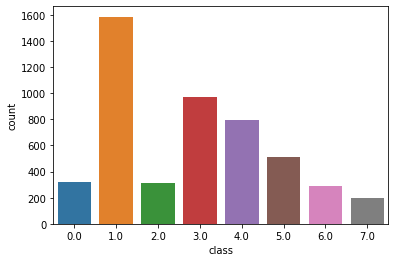

In [17]:
sns.countplot(x = "class" , data  = data_df)

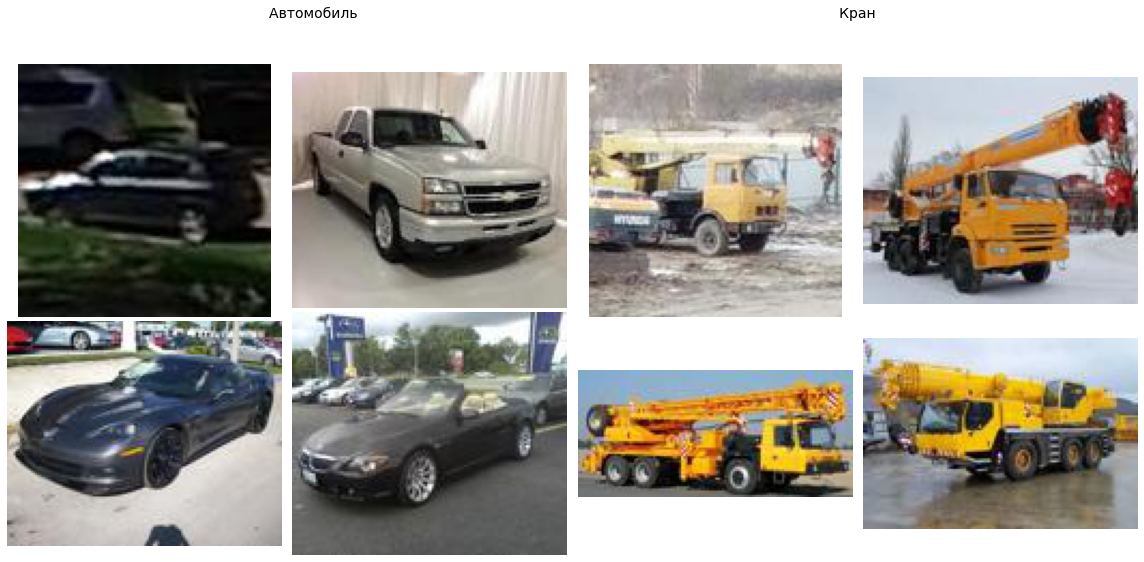

In [18]:
# посмотрим на картинки. Не забудем указать корретный путь до папки

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Автомобиль {" "*105} Кран', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['class'] == 1 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(DIR_TRAIN + f"{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['class'] == 0 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(DIR_TRAIN + f"{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [19]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.1, random_state=seed)

In [20]:
data_df.shape, train_df.shape, valid_df.shape

((4990, 2), (4491, 2), (499, 2))

In [21]:
train_dataset = ImageDataset(data_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [22]:
len(train_dataset)

4990

Посмотрим на полученные картинки.

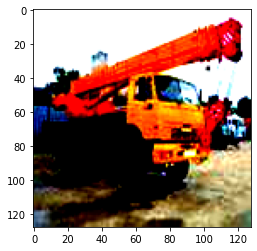

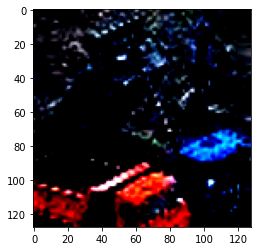

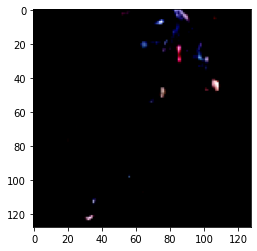

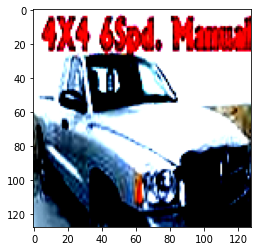

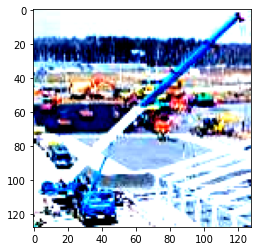

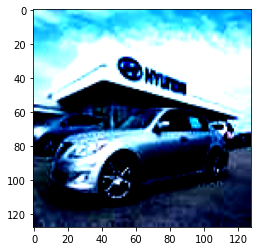

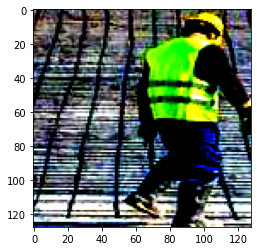

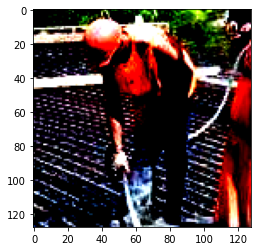

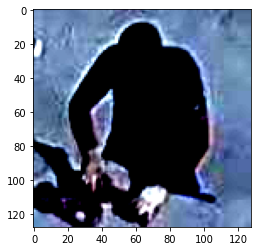

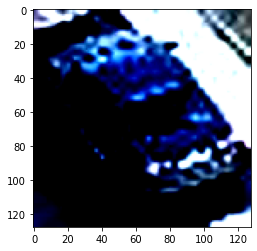

In [23]:
def show_image(image):
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

for i in range(90, 100):
    show_image(train_dataset[i])

In [24]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=10,
                                           shuffle=True,
                                           pin_memory=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=10,
                                           shuffle=False,
                                           pin_memory=True)

## Вспомогательные функции

In [25]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure(figsize=(16, 9))
    plt.title('{}'.format(title))
    dd = list(map(lambda x: x.cpu().detach().numpy(), train_history))
    plt.plot(dd, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

    plt.scatter(steps, val_history, marker='+', s=200, c='red', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [26]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        
        scheduler.step()
        
        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

## Модель

In [27]:
# Подгружаем модель, установим выход равный числу классов

model = models.efficientnet_v2_l(weights="IMAGENET1K_V1")
model.classifier[1] = nn.Linear(1280, 8)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth


  0%|          | 0.00/455M [00:00<?, ?B/s]

Если надо почистить память.

In [28]:
torch.cuda.empty_cache()

In [29]:
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

In [30]:
optimizer = optim.RAdam(model.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1, verbose = True)

Adjusting learning rate of group 0 to 1.0000e-04.


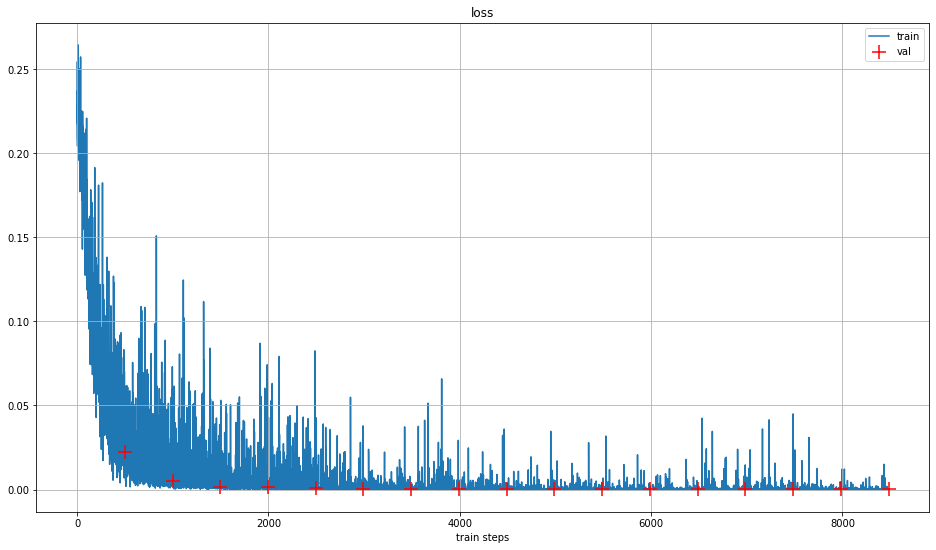

100%|██████████| 17/17 [57:57<00:00, 204.57s/it]

Adjusting learning rate of group 0 to 1.0000e-07.
Train loss: 0.048129695224088574
Val loss: 0.005408062758008186
Train acc: tensor(99.9599, device='cuda:0')
Val acc: tensor(100., device='cuda:0')


In [31]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, criterion, optimizer,
                                                                 train_loader, valid_loader, 17)

## Посмотрим метрики нашей итоговой модели на валидации.

In [32]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
        index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
        valid_predicts.append(index)

100%|██████████| 50/50 [00:04<00:00, 12.35it/s]


In [33]:
valid_df["pred"] = valid_predicts

# Посчитаем recall

In [34]:
val_accuracy = recall_score(valid_df['class'].values, valid_df['pred'].values, average = "macro")
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 1.0


## Предскажем для теста

In [35]:
test_df = pd.read_csv(PATH_TEST)
test_df = test_df.drop(["class"], axis = 1)

In [36]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform
        
    def _prepare_sample(self, image):
        
        H = image.shape[0]
        if H > 128:
            image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_AREA) # Сжатие
        elif H < 128:
            image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_LANCZOS4) # Растяжение
        else:
            image = image
    
        return image

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['ID_img']
        
        # читаем картинку
        image = cv2.imread(DIR_TEST+ f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = self._prepare_sample(image)

        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [37]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [38]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=1,
                                           shuffle=False,
                                           pin_memory=True)

# Предсказываем нашей моделью результат

In [39]:
model.eval()
predicts = []

for imgs in tqdm(test_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)
    for class_obj in pred:
        index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
        predicts.append(index)

100%|██████████| 2138/2138 [03:02<00:00, 11.70it/s]


In [40]:
test_df["class"] = predicts
test_df.head()

,ID_img,class
0,0.jpg,5
1,1.jpg,5
2,2.jpg,1
3,3.jpg,1
4,4.jpg,6


In [41]:
test_df.to_csv("submit.csv", index=False)